In [1]:
import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter

# import Python functions 
import sys

sys.path.append('../..')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN

In [2]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

In [3]:
# Sets data location
experiment = 'E338'
runname = '12710'

### Load dataset

In [4]:
# Loads dataset
dataloc = '../../data/raw/' + experiment + '/' + experiment + '_' + runname + '/' + experiment + '_'  +runname + '.mat'
mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
data_struct = mat['data_struct']

# Extracts number of steps
stepsAll = data_struct.params.stepsAll
if stepsAll is None or len(np.atleast_1d(stepsAll)) == 0:
    stepsAll = [1]

# calculate xt calibration factor
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

# cropping aspect ratio 
xrange = 100 
yrange = xrange


# gaussian filter parameter
hotPixThreshold = 1e3
sigma = 5
threshold = 5

In [5]:
# Extract current profiles and 2D LPS images 
xtcavImages_list = []
horz_proj_list = []

for a in range(len(stepsAll)):
    if len(stepsAll) == 1:
        raw_path = data_struct.images.DTOTR2.loc
    else: 
        raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    DTOTR2datalocation = '../../data/raw/'+ experiment + '/' + match.group(0)

    with h5py.File(DTOTR2datalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    
    # Transpose to shape: (H, W, N)
    DTOTR2data_step = np.transpose(data_raw, (2, 1, 0))
    xtcavImages_step = DTOTR2data_step - data_struct.backgrounds.DTOTR2[:,:,np.newaxis].astype(np.float64)
    
    for idx in range(DTOTR2data_step.shape[2]):
        if idx is None:
            continue
        image = xtcavImages_step[:,:,idx]
        
        # crop images 
        image_cropped, _ = cropProfmonImg(image, xrange, yrange, plot_flag=False)
        img_filtered = median_filter(image_cropped, size=3)
        hotPixels = img_filtered > hotPixThreshold
        img_filtered = np.ma.masked_array(img_filtered, hotPixels)
        processed_image = gaussian_filter(img_filtered, sigma=sigma, radius = 6*sigma + 1)
        processed_image[processed_image < threshold] = 0.0
        Nrows = np.array(image_cropped).shape[0]
        [centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

        # centroid correcion
        centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
        centroid_corrections[np.isnan(centroid_corrections)] = 0

        # shift images
        image_shifted = np.empty_like(image_cropped)
        for row in range(image_cropped.shape[0]):
            shift = int(-centroid_corrections[row])
            image_shifted[row] = np.roll(image_cropped[row], shift)
        # calcualte current profiles 
        horz_proj_idx = np.sum(image_cropped, axis=0)
        horz_proj_idx = horz_proj_idx[:,np.newaxis]
        image_shifted = image_shifted[:, :, np.newaxis]
        
        # combine current profiles into one array 
        horz_proj_list.append(horz_proj_idx)

        # combine images into one array 
        xtcavImages_list.append(image_shifted)

xtcavImages = np.concatenate(xtcavImages_list, axis=2)
horz_proj = np.concatenate(horz_proj_list, axis=1)

# Keeps only the data with a common index
DTOTR2commonind = data_struct.images.DTOTR2.common_index -1 
horz_proj = horz_proj[:,DTOTR2commonind]
xtcavImages = xtcavImages[:,:,DTOTR2commonind]

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_31722/1755272755.py:39: RuntimeWarning: invalid value encountered in divide
  centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)


In [6]:
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct)

ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = bsaScalarData[ampl_idx, :]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = bsaScalarData[phase_idx, :]

xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

plot_titles = ['Tcav phase -90 deg', '0 deg', '+90 deg']

### Calculate the current profile normalizing the integral to the charge

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_31722/4093466427.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)


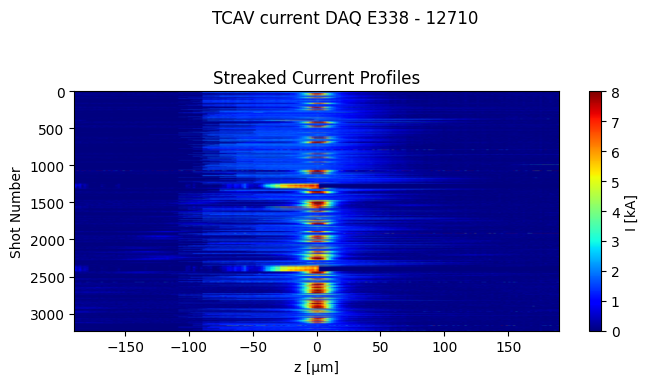

In [7]:
isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(isChargePV) if val]
charge = bsaScalarData[pvidx, :] * 1.6e-19  # in C 

minus_90_idx = np.where((xtcavPhase >= -91) & (xtcavPhase <= -89))[0]
plus_90_idx = np.where((xtcavPhase >= 89) & (xtcavPhase <= 91))[0]
all_idx = np.sort(np.append(minus_90_idx,plus_90_idx))
# all_idx = np.arange(xtcavImages.shape[2])
currentProfile_all = [] 

# Process all degree shots
for ij in range(len(all_idx)):
    idx = all_idx[ij]
    streakedProfile = horz_proj[:,idx]

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_all.append(currentProfile)
    
currentProfile_all = np.array(currentProfile_all)


# Plot
plt.figure(figsize=(7, 4))

# # Subplot for -90°
# plt.subplot(2, 1, 1)
extent_x = tvar * 3e8 * 1e6  # Convert to microns
plt.imshow(currentProfile_all, aspect='auto', cmap='jet', vmin=0, vmax=8, extent=[extent_x[0], extent_x[-1], all_idx[-1], all_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title('Streaked Current Profiles')
plt.colorbar(label='I [kA]')

plt.suptitle(f"TCAV current DAQ {experiment} - {runname}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate bunch separation using *find_peaks*

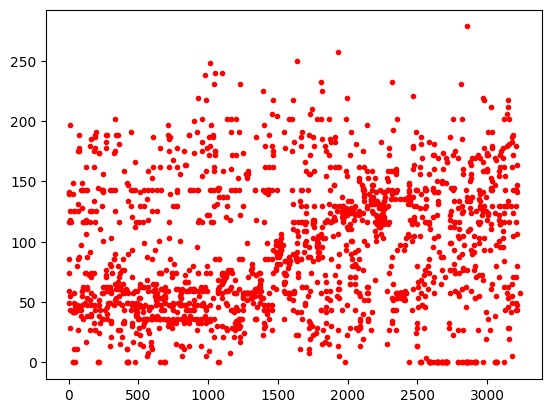

In [8]:
from scipy.signal import find_peaks, peak_prominences

bunchSeparation_all = []
currentRatio_all = []

separationCutoff = 0.05

for ij in range(len(all_idx)):
    profile = currentProfile_all[ij, :] 
    peaks, _ = find_peaks(profile)
    prominences = peak_prominences(profile, peaks)[0]
    if len(prominences) < 2:
        bunchSeparation_all.append(0)
        continue
    
    top2_indices = np.argsort(prominences)[-2:]
    pos = peaks[top2_indices]

    peak_separation = abs(pos[0] - pos[1])

    if abs(prominences[top2_indices[1]]) * separationCutoff > abs(prominences[top2_indices[0]]):
        peak_separation = 0

    bunchSeparation_all.append(peak_separation * xtcalibrationfactor)
    currentRatio_all.append(profile[pos[1]] / profile[pos[0]])

bunch_sep_um = np.array(bunchSeparation_all) * 3e8 * 1e6
currentRatio_all = np.array(currentRatio_all)

# goodShots = np.where(currentRatio_all < 16)[0]

plt.plot(all_idx, bunch_sep_um, 'r.')

### Bi-Gaussian Fit to Current Profiles

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_31722/3662380146.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)


Fit failed at index 669
Fit failed at index 1104
Fit failed at index 1110
Fit failed at index 1141
Fit failed at index 1142
Fit failed at index 1329
Fit failed at index 1388
Fit failed at index 1397
Fit failed at index 1415
Fit failed at index 1418
Fit failed at index 1420
Fit failed at index 1424
Fit failed at index 1427
Fit failed at index 1428
Fit failed at index 1525
Fit failed at index 1531
Fit failed at index 1535
Fit failed at index 1536
Fit failed at index 1553
Fit failed at index 1555
Fit failed at index 1556
Fit failed at index 1563
Fit failed at index 1565
Fit failed at index 1633
Fit failed at index 1634
Fit failed at index 1640


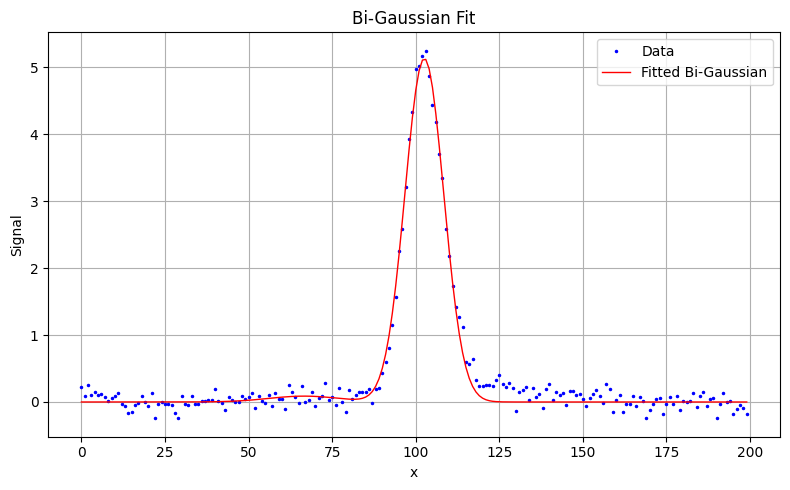

In [9]:
from scipy.optimize import curve_fit

# fit bi-Gaussian to -90 deg 

# Define the bi-Gaussian function
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

mean1 = []
mean2 = []
amp1 = []
amp2 = []
sigma1 = []
sigma2 = []
R_squared = []

params = []

for ij in range(len(all_idx)):
    y = currentProfile_all[ij, :]
    x = np.arange(len(y))

    # Initial guess: [A1, mu1, sigma1, A2, mu2, sigma2]
    if xtcavPhase[all_idx][ij] < 0:
        initial_guess = [np.max(y), 100, 4, np.max(y)*0.1, 60 + ij*0.15, 4]
    elif xtcavPhase[all_idx][ij] > 0:
        initial_guess = [np.max(y), 100, 4, np.max(y)*0.1, 60, 4]
    
    try:
        popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)
    except RuntimeError:
        print(f"Fit failed at index {ij}")
        mean1.append(np.nan)
        mean2.append(np.nan)
        amp1.append(np.nan)
        amp2.append(np.nan)
        sigma1.append(np.nan)
        sigma2.append(np.nan)
        params.append([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
        R_squared.append(np.nan)
        continue

    # Extract parameters
    A1, mu1_val, sig1, A2, mu2_val, sig2 = popt
    mean1.append(mu1_val)
    mean2.append(mu2_val)
    amp1.append(A1)
    amp2.append(A2)
    sigma1.append(sig1)
    sigma2.append(sig2)
    params.append(popt)

    # Evaluate fit
    y_fit = bi_gaussian(x, *popt)
    SST = np.sum((y - np.mean(y))**2)
    SSR = np.sum((y - y_fit)**2)
    R_squared.append(1 - SSR / SST)

# Convert results to arrays
mean1 = np.array(mean1)
mean2 = np.array(mean2)
amp1 = np.array(amp1)
amp2 = np.array(amp2)
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
R_squared = np.array(R_squared)

goodShots = np.where((R_squared > 0.97) & (amp1 < 50))[0]
# Plot the sigma of the drive and witness
# Plot the data and the fit

# Plot a single fit (last one by default)
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data', ms = 3)
plt.plot(x, bi_gaussian(x, *popt), 'r-', label='Fitted Bi-Gaussian', linewidth = 1)
plt.xlabel('x')
plt.ylabel('Signal')
plt.title('Bi-Gaussian Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Gaussian Mixture Model (GMM) for Bunch Separation Estimation

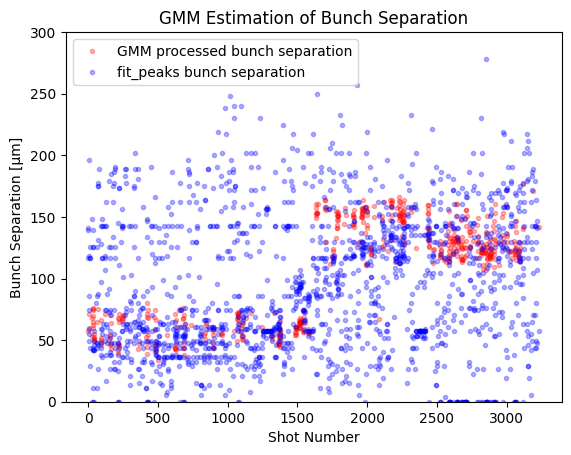

In [10]:
from sklearn.mixture import GaussianMixture

mean1 = []
mean2 = []
amp2 = []
sigma1 = []
sigma2 = [] 
weight1 = []
weight2 = []

for ij in range(len(all_idx)):
    y = currentProfile_all[ij, :]
    x = np.arange(len(y))
    cp = np.column_stack((x,y))
    if all_idx[ij] < 0.5*np.max(all_idx):
        gm = GaussianMixture(n_components=6, random_state=0).fit(cp)
    
        m1 = gm.means_[0][0]
        m2 = gm.means_[1][0]
        s1 = np.sqrt(gm.covariances_[0][0][0])
        s2 = np.sqrt(gm.covariances_[1][0][0])
        w1 = gm.weights_[0]
        w2 = gm.weights_[1]
        mean1.append(m1)
        mean2.append(m2)
        amp2.append(currentProfile_all[ij,int(m2)])
        sigma1.append(s1)
        sigma2.append(s2)
        weight1.append(w1)
        weight2.append(w2)
    else:
        gm = GaussianMixture(n_components=4, random_state=0).fit(cp) 
        
        m1 = gm.means_[0][0]
        m2 = gm.means_[3][0]
        s1 = np.sqrt(gm.covariances_[0][0][0])
        s2 = np.sqrt(gm.covariances_[3][0][0])
        w1 = gm.weights_[0]
        w2 = gm.weights_[3]
        mean1.append(m1)
        mean2.append(m2)
        amp2.append(currentProfile_all[ij,int(m2)-10])
        sigma1.append(s1)
        sigma2.append(s2)
        weight1.append(w1)
        weight2.append(w2)


mean1 = np.array(mean1)
mean2 = np.array(mean2)
amp2 = np.array(amp2 )
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
weight1 = np.array(weight1)
weight2 = np.array(weight2)

bunchSeparation_all_fit = (mean1[goodShots] - mean2[goodShots]) * xtcalibrationfactor * 1e6 * 3e8 # in microns 
plt.plot(all_idx[goodShots], bunchSeparation_all_fit, 'r.', label = 'GMM processed bunch separation', alpha = 0.3)
plt.plot(all_idx, bunch_sep_um, 'b.', label='fit_peaks bunch separation', alpha = 0.3)
# plt.plot(all_idx[goodShots_bigaus],biguas_fit, 'g.', label = 'Bi-Gaussian', alpha = 0.8 )
plt.title("GMM Estimation of Bunch Separation")
plt.xlabel("Shot Number")
plt.ylabel("Bunch Separation [μm]")
plt.ylim((0,300))
plt.legend()
plt.show()

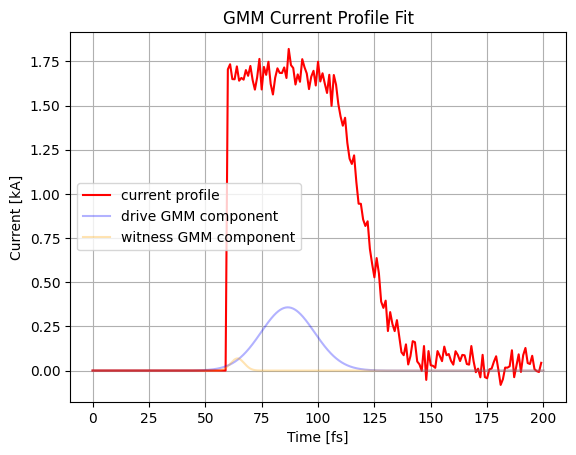

In [11]:
from scipy.stats import norm
i  = 254 # shot number

# Define parameters
mu1 = mean1[i]       # mean
s1 = sigma1[i]  # standard deviation
w1 = weight1[i]

mu2 = mean2[i]
s2 = sigma2[i]
w2 = weight2[i]

# Generate x values
x = np.linspace(0, 200, 1000)

# Compute normal distribution
gaussian1 = norm.pdf(x, mu1, s1)
gaussian2 = norm.pdf(x, mu2, s2)
y1 = gaussian1 * w1* np.max(currentProfile_all[i,:]) / np.max(gaussian1)
y2 = gaussian2 * w2* np.max(currentProfile_all[i,:]) / np.max(gaussian2)

# Plot
plt.plot(currentProfile_all[i,:], 'red', label = "current profile")
plt.plot(x, y1, label=f'drive GMM component', color='blue', alpha = 0.3)
plt.plot(x, y2, label=f'witness GMM component', color='orange', alpha = 0.3)
plt.title('GMM Current Profile Fit')
plt.xlabel('Time [fs]')
plt.ylabel('Current [kA]')
plt.grid(True)
plt.legend()
plt.show()

### Model Training

In [12]:
# 20-best parameter fit (bsaScalar PVs + step number)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
steps = data_struct.scalars.steps[DTOTR2commonind]
predictor = np.vstack((bsaScalarData[:,all_idx[goodShots]],steps[all_idx[goodShots]])).T
bs = bunchSeparation_all_fit.reshape(-1,1)

x_scaler = MinMaxScaler()
bs_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(predictor)
bs_scaled = bs_scaler.fit_transform(bs)

# 80/20 train-test split
x_train_full, x_test_scaled, bs_train_full, bs_test_scaled = train_test_split(
    x_scaled, bs_scaled, test_size=0.2)

# 20% validation split 
x_train_scaled, X_val, bs_train_scaled, Y_val = train_test_split(
    x_train_full, bs_train_full, test_size=0.2)

# Convert to PyTorch tensors
X_train = torch.tensor(x_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(x_test_scaled, dtype=torch.float32)
Y_train = torch.tensor(bs_train_scaled, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)
Y_test = torch.tensor(bs_test_scaled, dtype=torch.float32)

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=24, shuffle=True)

In [13]:
import time

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 500),
            nn.ReLU(),
            nn.Linear(500,200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, out_dim)
        )
    def forward(self, x):
        return self.model(x)

model = MLP(X_train.shape[1], Y_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))
loss_fn = nn.MSELoss()


# Training loop 
n_epochs = 200
patience = 15
best_val_loss = float('inf')
early_stop_counter = 0

t0 = time.time()

# Fit the nn model on the training set
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dl)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, Y_val).item()
        val_losses.append(val_loss)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            break
    
model.load_state_dict(best_model_state)
    
# Evaluate model
model.eval()
with torch.no_grad():
    pred_train_scaled = model(X_train).numpy()
    pred_test_scaled = model(X_test).numpy()

# Inverse transform predictions
pred_train_full = bs_scaler.inverse_transform(pred_train_scaled)
pred_test_full = bs_scaler.inverse_transform(pred_test_scaled)
bs_train_true = bs_scaler.inverse_transform(bs_train_scaled)
bs_test_true = bs_scaler.inverse_transform(bs_test_scaled)
elapsed = time.time() - t0
print("Elapsed time [mins] = {:.1f} ".format(elapsed/60))

# Compute R²
def r2_score(true, pred):
    RSS = np.sum((true - pred)**2)
    TSS = np.sum((true - np.mean(true))**2)
    return 1 - RSS / TSS if TSS != 0 else s0

print("Train R²: {:.2f} %".format(r2_score(bs_train_true.ravel(), pred_train_full.ravel()) * 100))
print("Test R²: {:.2f} %".format(r2_score(bs_test_true.ravel(), pred_test_full.ravel()) * 100))


Elapsed time [mins] = 0.0 
Train R²: 93.72 %
Test R²: 87.21 %


In [14]:
# import joblib
# joblib_file = 'model/MLP_E338_12710_21param.pkl'  
# joblib.dump(nn_model_curprof, joblib_file)

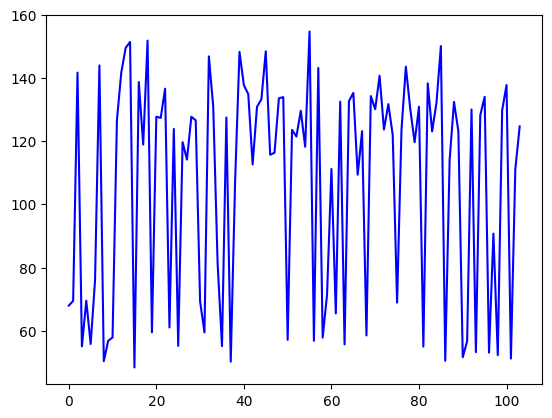

In [15]:
plt.plot(pred_test_full, 'b-')

### Model Validation


In [16]:
pred.shape

torch.Size([20, 1])

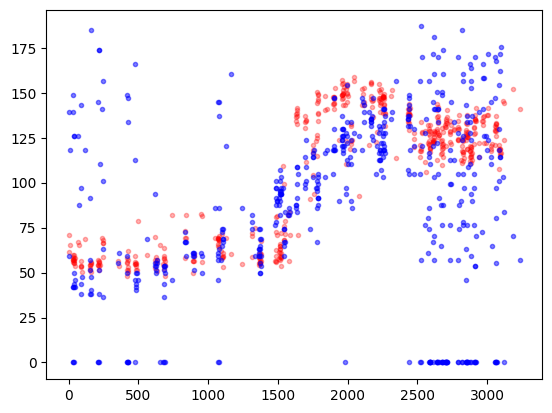

In [20]:
with torch.no_grad():
    x = torch.tensor(x_scaled, dtype=torch.float32)
    pred = bs_scaler.inverse_transform(model(x).numpy())

plt.plot(all_idx[goodShots],pred, 'r.', alpha = 0.3, label = 'MLP prediction')
# plt.plot(all_idx[goodShots], bunchSeparation_all_fit, 'b.', alpha = 0.2, label = 'GMM processed')
plt.plot(all_idx[goodShots],bunch_sep_um[goodShots], 'b.', label = 'unprocessed', alpha = 0.5)

In [18]:
x_scaled.shape

(519, 131)

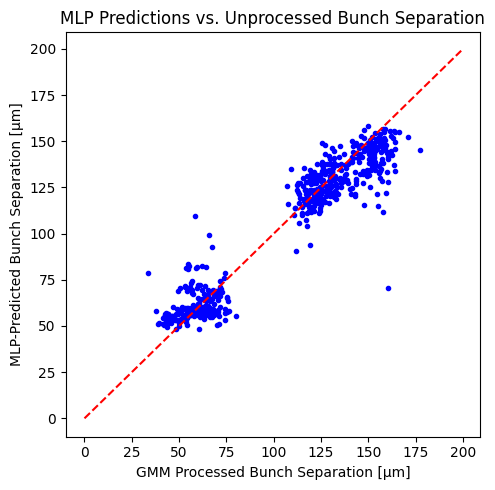

In [19]:
fig = plt.figure(figsize=(5,5))
plt.plot(bunchSeparation_all_fit,pred, 'b.')
plt.xlabel("GMM Processed Bunch Separation [μm]")
plt.ylabel("MLP-Predicted Bunch Separation [μm]")
plt.title("MLP Predictions vs. Unprocessed Bunch Separation")
plt.plot(np.arange(0,200), np.arange(0,200), 'r--')
plt.tight_layout()